In [115]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
import random
from keras.datasets import mnist
from keras.models import Model
from keras import layers
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Flatten,concatenate,Dense,Lambda,Dropout
from keras.layers import Input
import tensorflow as tf

### 加载数据

In [116]:
path = "./UJIIndoorLoc/children_13/sorted/00_sorted.csv"
train_df = pd.read_csv(path,header=0)
print(train_df.shape)
a = train_df.mean()
a["WAP004"]
for i in train_df.columns[:520]:
    if a[i]==-110:
        del train_df[i]
print(train_df.shape)
train_df["REF"] = pd.factorize(train_df["REF"])[0].astype(int)#将标签映射到顺序数字上
labels = train_df.REF.values
features = train_df.drop(columns=['TIMESTAMP','PHONEID','USERID','RELATIVEPOSITION',
                                'SPACEID','BUILDINGID','FLOOR','LATITUDE','LONGITUDE',
                                'BF','REF']).values
features,labels,features.shape

(1059, 531)
(1059, 130)


(array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64),
 array([ 0,  0,  0, ..., 53, 53, 53]),
 (1059, 119))

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.3,
                                                    random_state= 150,
                                                    #random_state：可以理解为随机数种子，主要是为了复现结果而设置
                                                    stratify=labels)#保证划分的test中的所有标签齐全
X_train,Y_train = shuffle(X_train, Y_train)
Y_train,Y_test

(array([31, 31, 26,  9, 46, 47, 26, 44,  7, 18, 51, 47, 13, 17, 11, 39, 25,
        35, 33, 14, 24, 30, 24, 15, 31, 13, 45, 22, 46, 48, 37, 24,  7,  8,
         1, 37,  0, 28, 21, 32, 48, 49, 50, 47, 43, 23, 25, 49,  4, 13, 37,
        15, 27, 15,  7, 14, 10, 44, 41, 20, 31, 21, 13, 27, 10, 24, 47, 17,
         0, 44, 33, 23, 28, 35, 21, 38, 49, 15, 16, 25, 12, 27, 53, 18,  3,
        25, 39, 36, 46, 25, 19,  6,  3, 12, 21, 49, 13, 31, 12,  7, 46, 38,
         1, 25, 16, 48, 24, 42, 40, 15, 44, 27, 14, 42, 35, 40,  7, 38, 17,
         0,  9, 29, 47, 20, 12, 39, 49,  4, 51, 47, 37,  8, 51, 14, 52, 45,
        52, 25, 20,  5, 25, 45, 48, 45, 29, 12, 47, 28, 36, 41, 31,  1, 31,
        30, 32, 18, 20,  9, 13, 17, 22,  2, 24, 35, 12, 44, 14, 28,  5,  0,
        13, 45, 17, 22, 19, 14, 11, 30, 33, 37, 26, 13, 31, 24, 37, 16, 12,
        16, 14, 29,  8, 26, 32, 28, 35, 42, 47, 26, 40, 25, 49, 31, 36, 32,
        13, 16, 20,  5, 15, 52, 24, 30, 19, 19, 29, 50, 52, 53, 41, 41, 14,
        11, 

In [118]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
scale = StandardScaler().fit(X_train)
X_train_transform = scale.transform(X_train)
X_test_transform = scale.transform(X_test)
Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)
input_shape = features.shape[1:]

### loss

In [119]:
#余弦相似度
def tf_cosine_distance(tensor1,tensor2):

    #把张量拉成矢量，这是我自己的应用需求
    tensor1 = tf.reshape(tensor1,shape=(1,-1))
    tensor2 = tf.reshape(tensor2, shape=(1, -1))

    # 求模长
    tensor1_norm = tf.sqrt(tf.reduce_sum(tf.square(tensor1)))
    tensor2_norm = tf.sqrt(tf.reduce_sum(tf.square(tensor2)))

    # 内积
    tensor1_tensor2 = tf.reduce_sum(tf.multiply(tensor1,tensor2))
    cosin = tensor1_tensor2/(tensor1_norm*tensor2_norm)

    return cosin

# 由于网络结构中将x_a，x_p，x_n直接拼接在了一起，所以使用了下标进行分割。在triplet loss中不需要使用y_true的值
margin = 1
def triplet_loss(y_true, y_pred, alpha = margin):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
 
    # distance between the anchor and the positive
#     pos_dist = K.sum(K.square(anchor-positive),axis=1)
    pos_dist = K.square(tf_cosine_distance(anchor,positive))
 
    # distance between the anchor and the negative
#     neg_dist = K.sum(K.square(anchor-negative),axis=1)
    neg_dist = K.square(tf_cosine_distance(anchor,negative))
 
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha#alpha为margin
    loss = K.maximum(basic_loss,0.0)
 
    return loss

### 样本对的构造

In [120]:
def create_triple(x_train,y_train):
    x_anchors=[]
    x_positives=[]
    x_negatives=[]
    for i in range(0, x_train.shape[0]):
        #随机选择一个样本x
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        #随机选择一个与x相同类型的样本x+
        indices_for_pos = np.squeeze(np.where(y_train == y))
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        
        #随机选择一个与x不同同类型的样本x-
        indices_for_neg = np.squeeze(np.where(y_train != y))
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors.append(x_anchor)
        x_positives.append(x_positive)
        x_negatives.append(x_negative)
        
    return np.array(x_anchors), np.array(x_positives), np.array(x_negatives)

train_a_pairs,train_p_pairs,train_n_pairs=create_triple(X_train_transform,Y_train)
test_a_pairs,test_p_pairs,test_n_pairs=create_triple(X_test_transform,Y_test)

### 特征提取网络

In [121]:
def featureNet(input_dim):
    inp = Input(shape=input_dim ,name = 'ap_feature')
    model = Dense(1024,activation='relu')(inp)
    model = Dense(512,activation='relu')(model)
    model = Dense(256,activation='relu')(model)
    output = Dense(119,activation='relu')(model)
    return Model(inp,output)

### 构建网络

In [122]:
base_network = featureNet(input_shape)
 
input_a = layers.Input(shape=input_shape)
input_p = layers.Input(shape=input_shape)
input_n = layers.Input(shape=input_shape)
 
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_p = base_network(input_p)
processed_n = base_network(input_n)
merged_vector = layers.concatenate([processed_a, processed_p, processed_n], axis=-1, name='merged_layer')
model = Model([input_a,input_p, input_n], merged_vector)
keras.utils.plot_model(model,"triplet_Model.png",show_shapes=True)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 119)]        0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 119)]        0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 119)]        0           []                               
                                                                                                  
 model_22 (Functional)          (None, 119)          809591      ['input_34[0][0]',               
                                                                  'input_35[0][0]',        

### training

In [123]:
from keras.optimizers import Adam
rms = RMSprop()
model.compile(loss=triplet_loss, optimizer=rms)
tr_y = np.empty((train_a_pairs.shape[0],1))
te_y = np.empty((test_a_pairs.shape[0],1))
history=model.fit([train_a_pairs,train_p_pairs,train_n_pairs], tr_y,
          batch_size=64,
          epochs=30,verbose=1,
          validation_data=([test_a_pairs,test_p_pairs,test_n_pairs], te_y))

Epoch 1/30
12/12 [==============================] - 2s 49ms/step - loss: 1.0584 - val_loss: 1.1457
Epoch 2/30
12/12 [==============================] - 0s 31ms/step - loss: 0.8939 - val_loss: 1.1922
Epoch 3/30
12/12 [==============================] - 0s 29ms/step - loss: 0.8219 - val_loss: 1.1349
Epoch 4/30
12/12 [==============================] - 0s 28ms/step - loss: 0.8188 - val_loss: 1.1207
Epoch 5/30
12/12 [==============================] - 0s 39ms/step - loss: 0.8263 - val_loss: 1.0888
Epoch 6/30
12/12 [==============================] - 0s 29ms/step - loss: 0.7809 - val_loss: 1.1541
Epoch 7/30
12/12 [==============================] - 0s 32ms/step - loss: 0.8355 - val_loss: 1.1247
Epoch 8/30
12/12 [==============================] - 0s 30ms/step - loss: 0.7775 - val_loss: 1.1553
Epoch 9/30
12/12 [==============================] - 0s 29ms/step - loss: 0.7318 - val_loss: 1.1650
Epoch 10/30
12/12 [==============================] - 0s 30ms/step - loss: 0.7446 - val_loss: 1.1567
Epoch 11/

### 结果可视化

10/10 [==============================] - 0s 4ms/step


C:\Users\xfp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xfp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xfp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xfp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xfp\AppData\Local\Temp\ipykernel_9680\2150404696.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modif

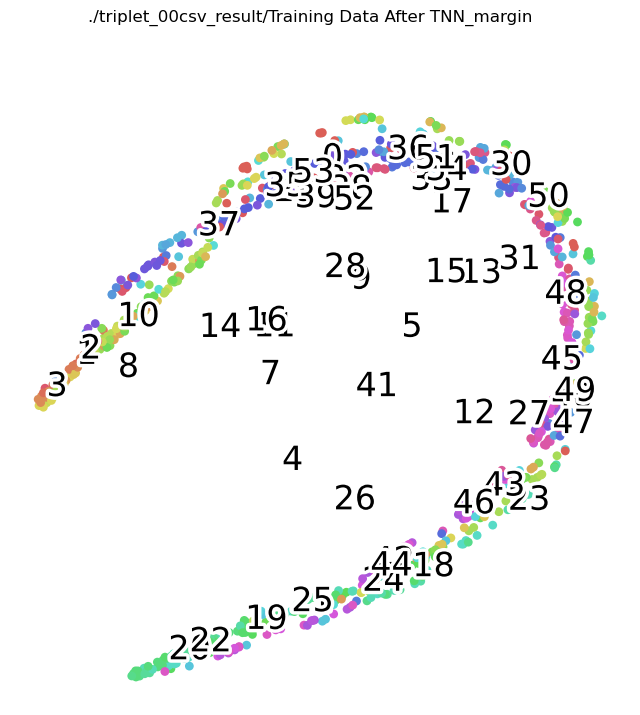

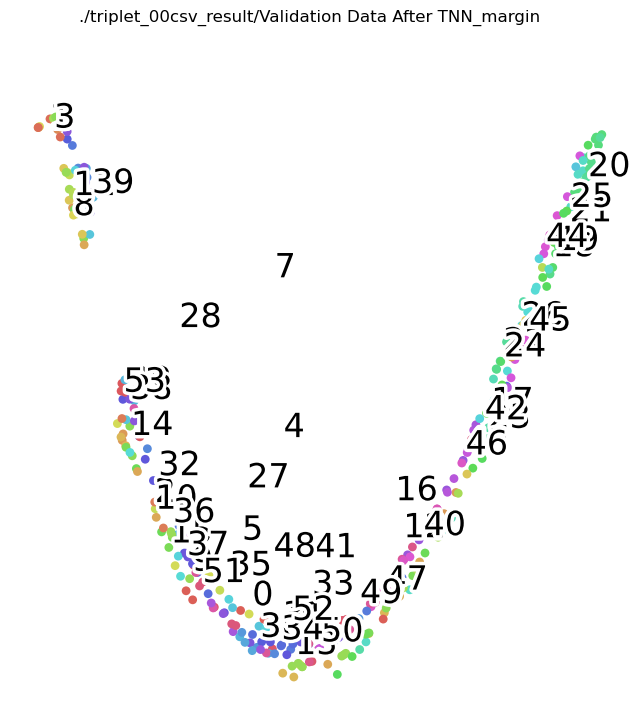

In [124]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 54))
 
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
 
    # We add the labels for each digit.
    txts = []
    for i in range(54):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
tsne = TSNE()
X_train_trm = base_network.predict(X_train)
X_test_trm = base_network.predict(X_test)
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)
scatter(train_tsne_embeds, Y_train, './triplet_00csv_result/Training Data After TNN_margin')
scatter(eval_tsne_embeds, Y_test, './triplet_00csv_result/Validation Data After TNN_margin')